One Important thing is to notice that I haven't done any exploration on the dataset in this code. This is due to the fact that I downloaded all the pictures thorugh web scraping and then prepared each image manually so I know what and how are the pictures. If you are to use this dataset it is recommended that you first explore the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datadir="/content/drive/MyDrive/Celebrity_recognition_dataset"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        datadir,
        image_size=(225,225),
        validation_split=0.2,
        subset="training",
        seed=123,
)

val_ds= tf.keras.preprocessing.image_dataset_from_directory(
      datadir,
      image_size=(225,225),
      validation_split=0.2,
      subset="validation",
      seed=123,
)

Found 4519 files belonging to 17 classes.
Using 3616 files for training.
Found 4519 files belonging to 17 classes.
Using 903 files for validation.


An Important thing to note is that even I haven't explicitly defined batch size as tensorflow automatically sets it to 32. this will be proven during training. if there are 3616 / 13 = 113 steps during training, this means that the training data is in batches of 32

In [ ]:
# Cache and prefetch the datasets
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Defining callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.1,
                                                    patience=3,
                                                    min_lr=1e-6)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=9,
                                                  restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/celeb_model.h5',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                verbose=1)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(225, 225, 3),
                                                  include_top=False,
                                                  weights='imagenet')


base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(17, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 256)               327936    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 17)                4369      
                                                                 
Total params: 4381876 (16.72 MB)
Trainable params: 168

In [ ]:
history = model1.fit(train_ds,
                    epochs=200,
                    validation_data=val_ds,
                    callbacks=[lr_scheduler, early_stopping, checkpoint,])

Epoch 1/200
113/113 [==============================] - ETA: 0s - loss: 1.5397 - accuracy: 0.5304
Epoch 1: val_loss improved from inf to 0.82316, saving model to /content/drive/MyDrive/celeb_model.h5
113/113 [==============================] - 63s 486ms/step - loss: 1.5397 - accuracy: 0.5304 - val_loss: 0.8232 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.8150
Epoch 2: val_loss improved from 0.82316 to 0.63434, saving model to /content/drive/MyDrive/celeb_model.h5
113/113 [==============================] - 54s 481ms/step - loss: 0.5816 - accuracy: 0.8150 - val_loss: 0.6343 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.9165
Epoch 3: val_loss did not improve from 0.63434
113/113 [==============================] - 54s 481ms/step - loss: 0.2730 - accuracy: 0.9165 - val_loss: 0.6775 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 4/200
1

Plotting the training graphs for evaluation

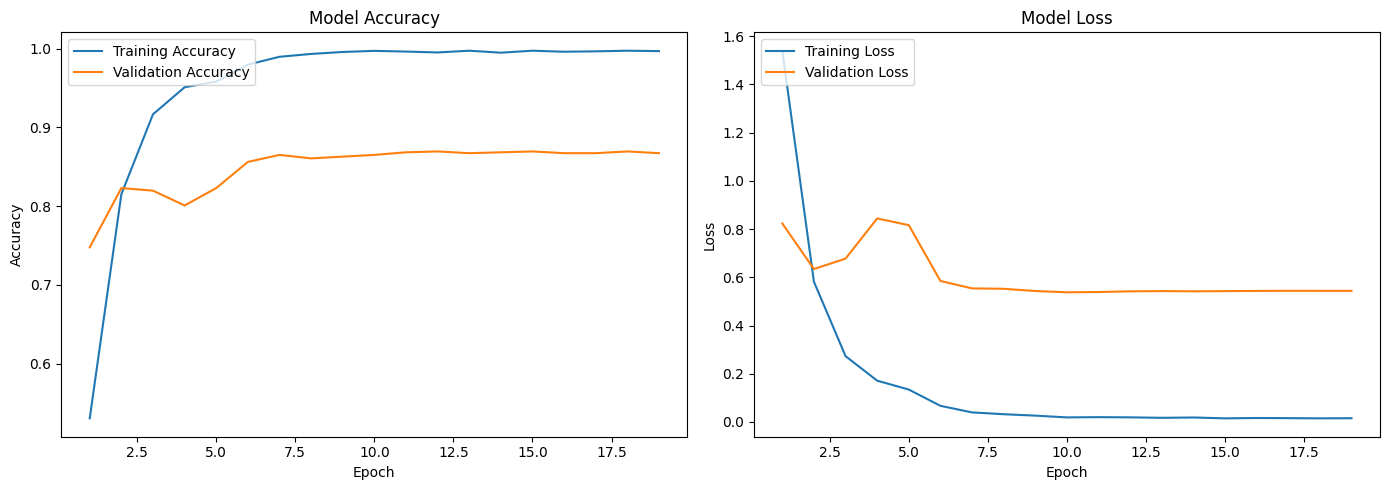

In [ ]:
import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


The model had reached its peak performance at epoch 10 after which val loss didn;t increase so the early stop callback stopped it at 19 epoch and the check point callback had already saved the best model at 10th epoch


---

Although the model is performing well on the validation data set ,86% accuracy, a large gap between training accuracy, 99%, and validation accuracy, 86% shows overfiiting


---

The graph shows that the overfitting started around 3rd epoch after which there was no net decrease in validation loss however training loss continued to decrease

Now I'll try techniques to overcome model overfitting

Note: reading the data agian because the runtime on colab had disconnected

In [ ]:
datadir="/content/drive/MyDrive/Celebrity_recognition_dataset"
train = tf.keras.preprocessing.image_dataset_from_directory(
        datadir,
        image_size=(225,225),
        validation_split=0.2,
        subset="training",
        seed=123,
)

val= tf.keras.preprocessing.image_dataset_from_directory(
      datadir,
      image_size=(225,225),
      validation_split=0.2,
      subset="validation",
      seed=123,
)

Found 4519 files belonging to 17 classes.
Using 3616 files for training.
Found 4519 files belonging to 17 classes.
Using 903 files for validation.


In [ ]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
])

# Create the datasets with data augmentation
train_augmented = train.map(lambda x, y: (data_augmentation(x, training=True), y))

# Base model with pre-trained weights
base_model2 = tf.keras.applications.EfficientNetB0(input_shape=(225, 225, 3),
                                                  include_top=False,
                                                  weights='imagenet')

base_model2.trainable=False
# Build the model
model2 = tf.keras.Sequential([
    base_model2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(17, activation='softmax')
])

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.1,
                                                    patience=3,
                                                    min_lr=1e-6)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=9,
                                                  restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/celeb_model2.h5',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                verbose=1)

model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 256)               327936    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 17)                4369      
                                                                 
Total params: 4381876 (16.72 MB)
Trainable params: 33

In [ ]:

# Train the model
history = model2.fit(train_augmented,
                    epochs=200,
                    validation_data=val,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])


Epoch 1/200
113/113 [==============================] - ETA: 0s - loss: 2.2628 - accuracy: 0.2796
Epoch 1: val_loss improved from inf to 1.69094, saving model to /content/drive/MyDrive/celeb_model2.h5
113/113 [==============================] - 67s 524ms/step - loss: 2.2628 - accuracy: 0.2796 - val_loss: 1.6909 - val_accuracy: 0.4873 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - ETA: 0s - loss: 1.7933 - accuracy: 0.4275
Epoch 2: val_loss improved from 1.69094 to 1.48012, saving model to /content/drive/MyDrive/celeb_model2.h5
113/113 [==============================] - 59s 515ms/step - loss: 1.7933 - accuracy: 0.4275 - val_loss: 1.4801 - val_accuracy: 0.5415 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - ETA: 0s - loss: 1.5717 - accuracy: 0.5075
Epoch 3: val_loss improved from 1.48012 to 1.37275, saving model to /content/drive/MyDrive/celeb_model2.h5
113/113 [==============================] - 58s 511ms/step - loss: 1.5717 - accuracy: 0.5075 - val_

Again plotting graph for analysis

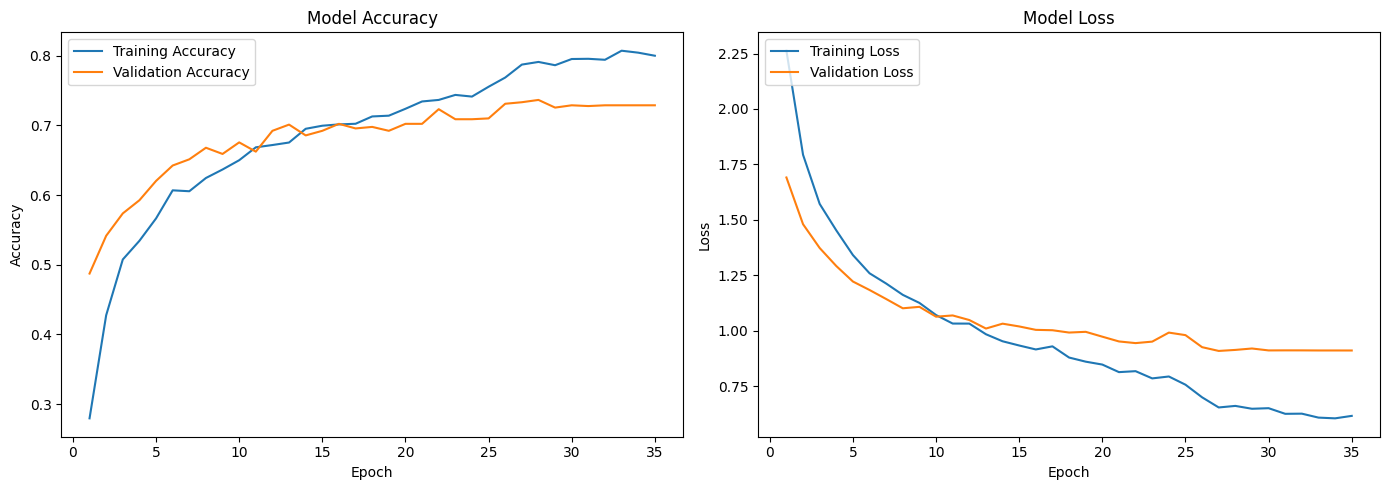

In [ ]:
import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The Graph Shows that this model avoided the problem of overfitting to a great extent, however the real problem lies in the fact that this model gave unsatisfactory results; It stopped effectively learning after reaching about 78% training accuracy and 73% validation accuracy

---


With these changes in preprocessing and in the model, I was able to overcome overfitting.

The model reached it's optima at epoch 27 with loss: 0.6534 - accuracy: 0.7871 - val_loss: 0.9084 - val_accuracy: 0.7331.

However this was at the cost of reduced accuracy. Earlier I was able to acheive 86% accuracy on the validation data set and now the accuracy is reduced to 73% on the validation dataset.


---



the reduced accuracy can be due to the fact that the changed model has much less trainable parameters; 1683265 compared to 332305

To test this hypothesis what I will do is to allow more parameters in the second model to be trained in a new model number 3.

**Note: To save computational resources the changes can be made on already trained model2 but as the model is not computationaly expensive I'll just make a new model**

A difference between model3 and model1 is that in model1 the base_model had last 20 layers not frozen whereas in model 3 the base_model has last 15 layers not frozen

In [ ]:
# Base model with pre-trained weights
base_model3 = tf.keras.applications.EfficientNetB0(input_shape=(225, 225, 3),
                                                  include_top=False,
                                                  weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Build the model
model3 = tf.keras.Sequential([
    base_model3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(17, activation='softmax')
])

# Compile the model
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.1,
                                                    patience=3,
                                                    min_lr=1e-6)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=9,
                                                  restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/celeb_model3.h5',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                verbose=1)

model3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_23 (Dense)            (None, 256)               327936    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 17)                4369      
                                                                 
Total params: 4381876 (16.72 MB)
Trainable params: 43

In [ ]:
# Train the model
history = model3.fit(train_augmented,
                    epochs=200,
                    validation_data=val,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

Epoch 1/200
113/113 [==============================] - ETA: 0s - loss: 1.8818 - accuracy: 0.4190
Epoch 1: val_loss improved from inf to 1.14581, saving model to /content/drive/MyDrive/celeb_model3.h5
113/113 [==============================] - 196s 2s/step - loss: 1.8818 - accuracy: 0.4190 - val_loss: 1.1458 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - ETA: 0s - loss: 1.0679 - accuracy: 0.6775
Epoch 2: val_loss improved from 1.14581 to 1.05364, saving model to /content/drive/MyDrive/celeb_model3.h5
113/113 [==============================] - 170s 2s/step - loss: 1.0679 - accuracy: 0.6775 - val_loss: 1.0536 - val_accuracy: 0.6921 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - ETA: 0s - loss: 0.8277 - accuracy: 0.7506
Epoch 3: val_loss improved from 1.05364 to 1.01570, saving model to /content/drive/MyDrive/celeb_model3.h5
113/113 [==============================] - 169s 1s/step - loss: 0.8277 - accuracy: 0.7506 - val_loss: 

as it could be seen from the training pattern that the model was starting to overfit after the 13th epoch I had saved the model at epoch 13 so that it does not get overwritten, as whenever the validation loss improves, even if it is insignificant the checkpoint callback will save the model at that instance.

Again although the epochs continued till epoch 26 there was no real improvement in the model, It was just overfitting as there was no improvement in validation accuracy and the early stop callback stopped the model after 10 consecutive epochs with no decrease in loss


---
**Although there are still a few hypothesis left to test to increase the model's validation accuracy, we have already acheived a accuracy of
89.8% on validation accuracy** - which is good considering the fact that the dataset is small, only about 210 images per class, and that the images are not extremely high quality- **and now due to model complexity it is impractical to train the model. for a further increase in accuracy even after acheiving 90% on validation set**


---
**plotting the training graphs for accuracy, loss validation accuracy and validation loss**





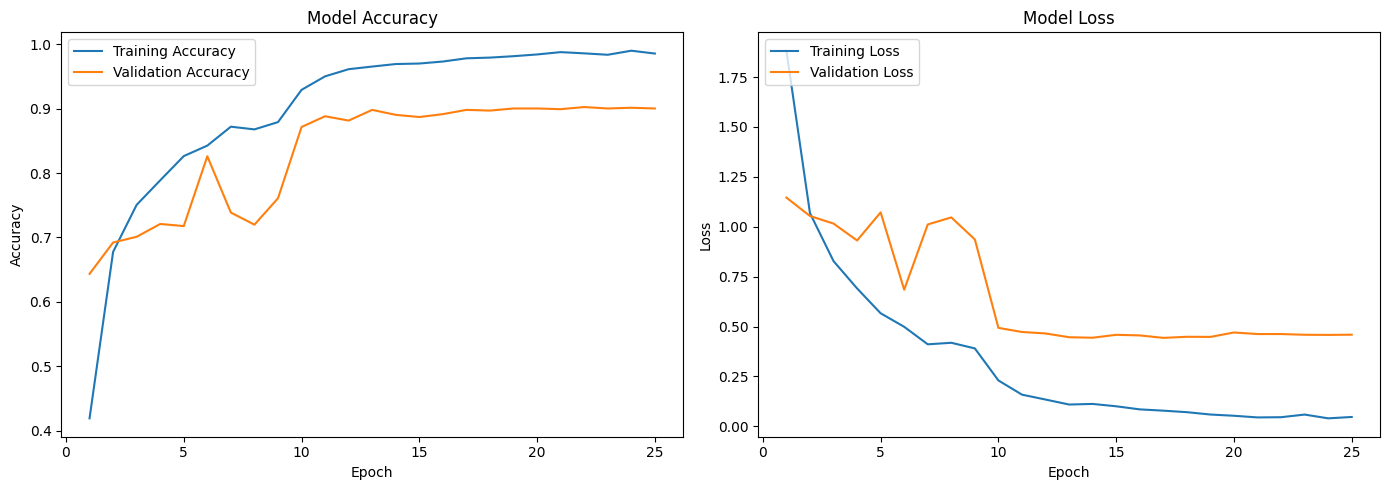

In [ ]:
import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

From the graph **it can be clearly seen that the model stopped getting better after aroung epoch 13**, as after that epoch both **validation accuracy and validation loss leveled out** and the **only improvement was on training accuracy and training loss, which is a clear indicator of overfitting.**

This graph also supports my inference made from looking at the training output pattern about the model overfitting after epoch 13


---


You will notice that I am loading the model for further testing it on images. it is due to the reason that the runtime had disconnected on google colab. The model I will be loading is the same one which was downloaded after the 13th epoch

In [ ]:
model_path = '/content/drive/MyDrive/celeb_model3.h5'

final_model=tf.keras.models.load_model(model_path)

final_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_23 (Dense)            (None, 256)               327936    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 17)                4369      
                                                                 
Total params: 4381876 (16.72 MB)
Trainable params: 43

The next block extracts true labels from the dataset so that the evaluation metrics can compare it

In [ ]:
# Collecting true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in val_ds:
    true_labels.extend(labels.numpy())
    predictions = final_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays for consistency
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


1/1 [==============================] - 0s 49ms/step


If you don't know these terms here is a simple explaination of them:

**Metrics printed in Classification Report**:
* Precision: The ratio of true positives to the sum of true and false positives.
* Recall (Sensitivity): The ratio of true positives to the sum of true * positives and false negatives.
* F1-score: The harmonic mean of precision and recall.
* Support: The number of true instances for each label.
* Accuracy: The overall accuracy is shown at the bottom of the report.
* Macro avg: The unweighted mean of the metrics across all classes.
* Weighted avg: The mean of the metrics weighted by the number of true instances for each class.



In [ ]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels)
print(f'Classification Report:\n{report}')

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.85        41
           1       0.78      0.94      0.85        53
           2       0.84      0.87      0.85        30
           3       0.94      0.95      0.94        62
           4       0.91      0.93      0.92        54
           5       0.96      0.78      0.86        55
           6       0.96      0.96      0.96        57
           7       0.93      0.89      0.91        56
           8       0.85      0.85      0.85        48
           9       0.80      0.91      0.85        53
          10       1.00      0.89      0.94        64
          11       0.87      0.94      0.91        51
          12       0.90      0.90      0.90        52
          13       0.98      0.91      0.94        66
          14       0.90      0.86      0.88        44
          15       0.85      0.90      0.87        61
          16       0.89      0.91      0.90        56

   

**Confusion Matrix**

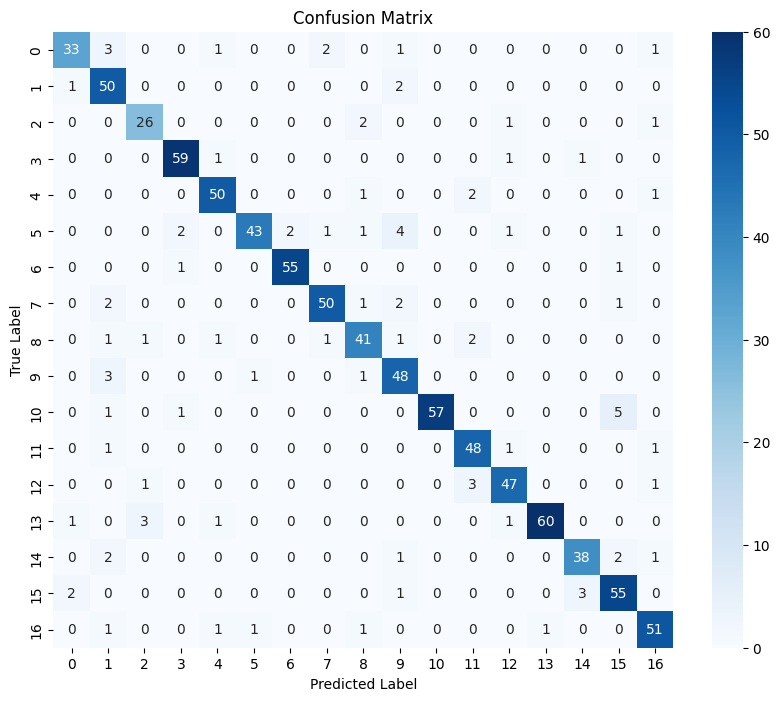

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

From the above evalutation metrices, it can be clearly seen that class 1, i.e: Chris Hemsworth has the least precision. It's precision is almost an outlier standing at 78%, with the closest precision for any other class being 84%. As accuracy can be described as the average of individual precisions of each class, It is safe to say that the class 1 (Chris Hemsworth) has a great effect of reducing the accuracy. One of the reasons might be due to the nature of the pictures of that class.


---

**Making predictions on Individual images**

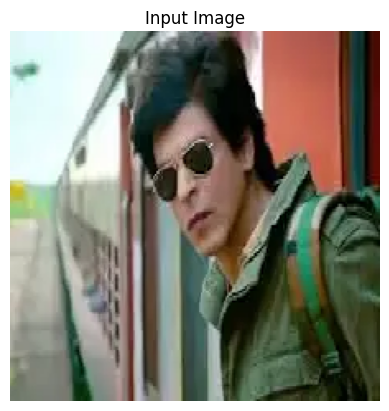

1/1 [==============================] - 0s 140ms/step
The predicted class is: ShahRukh_Khan


In [ ]:
datadir="/content/drive/MyDrive/Celebrity_recognition_dataset" # path to datset to retrieve class names
# Define the path to the individual image
image_path = "/content/shah rukh khan 1.jpeg"

# Function to load, preprocess, and display the image
def load_preprocess_and_display_image(img_path, img_size=(225, 225)):
    img = image.load_img(img_path, target_size=img_size)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to get class names from directory structure
def get_class_names(datadir):
    return sorted(os.listdir(datadir))

# Function to predict the class of an image
def predict_image(model, img_path, class_names):
    img_array = load_preprocess_and_display_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])+ 1 # +1 to change the range from 0-16 to 1-17 as the classes are read in 1-17
    return class_names[predicted_class_index]



# Get class names from the dataset directory
class_names = get_class_names(datadir)

# Predict the class of the image
predicted_classname = predict_image(final_model, image_path, class_names)
print(f"The predicted class is: {predicted_classname}")
